Astronomical Computing Assignment 3
Question 2 Using ADQL to Search for Bright Stars Around the Open Cluster M67
2.1 Task
A colleague is interested in the open cluster Messier 67 (RA = 132.825 deg, Dec = 11.8 deg) and is considering an observation proposal using the 2dF fibre positioner and HERMES spectrograph (effective for Gaia G band magnitudes < 14). They need to know if there are enough bright stars in this region for observation. Your task is to assist by querying data from Gaia DR3 and performing some basic analysis.
• Download all stars within 1 degree of the center of Messier 67 that are brighter than G = 14 in Gaia DR3 (the table is called gaiadr.gaia source) and include a crossmatch these stars with the 2MASS catalog and report your ADQL query text (use the """query""" notation)
• Determine how many stars are returned from the initial query.
• Identify any stars with bad 2MASS photometry, where ph qual is not ’AAA’.
• Identify any stars with negative (or non-positive) parallaxes in the Gaia data.
• Apply these two quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes). After applying the cuts, determine how many stars remain.
• Using the remaining stars, generate a figure with two panels (1 point per panel):
– (a) A color-magnitude diagram (CMD) of Gaia BP-RP vs. absolute G magnitude.
– (b) A 2MASS J-Ks vs. apparent K magnitude diagram.
• Save the figure as figures/cmds M67.png with a resolution of 200 dots per inch.
• Give your colleague a recommendation for the potential proposal when only judging the fibre usage.

To download all stars within 1 degree of the center of Messier 67 that are brighter than G = 14 in Gaia DR3 (the table is called gaiadr.gaia source) and include a crossmatch these stars with the 2MASS catalog and report your ADQL query text (use the """query""" notation)

In [21]:
from astroquery.gaia import Gaia
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import os

In [22]:
# Define the ADQL query
query = """
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, gaia.phot_g_mean_mag, 
       gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag,  -- Separate BP and RP magnitudes
       tmass.j_m, tmass.ks_m, tmass.ph_qual
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON xjoin.original_psc_source_id = tmass.designation
WHERE 1=CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), CIRCLE('ICRS', 132.825, 11.8, 1))
AND gaia.phot_g_mean_mag < 14
"""

# Launch the query to the Gaia archive
job = Gaia.launch_job(query)
result = job.get_results()

In [23]:
# Output the result count
print(f"Number of stars found: {len(result)}")

Number of stars found: 1018


In [24]:
# Step 3: Identify stars with bad 2MASS photometry (ph_qual not 'AAA')
bad_photometry_stars = result[result['ph_qual'] != 'AAA']

# Print the number of stars with bad photometry
print(f"Number of stars with bad 2MASS photometry: {len(bad_photometry_stars)}")

Number of stars with bad 2MASS photometry: 21


In [25]:
# Step 4: Identify stars with negative or non-positive parallaxes
bad_parallax_stars = result[result['parallax'] <= 0]

# Print the number of stars with bad parallaxes
print(f"Number of stars with negative or non-positive parallaxes: {len(bad_parallax_stars)}")

Number of stars with negative or non-positive parallaxes: 2


In [26]:
# Step 5: Apply quality cuts (remove stars with bad 2MASS photometry and non-positive parallaxes)
good_stars = result[(result['ph_qual'] == 'AAA') & (result['parallax'] > 0)]

# Print the number of stars that remain after the cuts
print(f"Number of stars remaining after quality cuts: {len(good_stars)}")

Number of stars remaining after quality cuts: 988


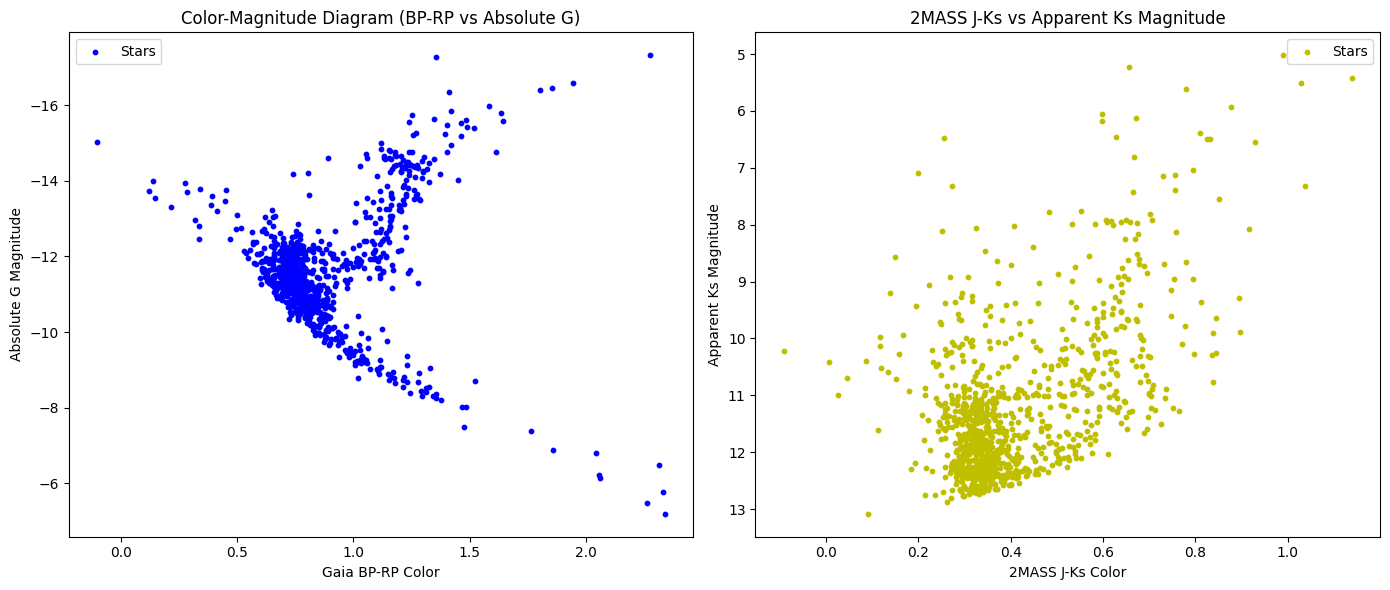

In [27]:
# Step 6: Generate the plots

# Convert parallax from milliarcseconds to arcseconds
parallax_arcsec = good_stars['parallax'] / 1000.0

# (a) Color-Magnitude Diagram (CMD)
bp_rp = good_stars['phot_bp_mean_mag'] - good_stars['phot_rp_mean_mag']  # Gaia BP-RP color
G = good_stars['phot_g_mean_mag']  # Gaia G magnitude
M_G = G + 5 * np.log10(parallax_arcsec) - 10  # Absolute G magnitude

# (b) 2MASS J-Ks vs Apparent Ks Magnitude
J = good_stars['j_m']  # 2MASS J magnitude
Ks = good_stars['ks_m']  # 2MASS Ks magnitude
J_Ks = J - Ks  # 2MASS J-Ks color

# Create the figure with two panels
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# (a) CMD: BP-RP vs. Absolute G magnitude
ax[0].scatter(bp_rp, M_G, s=10, c='b', label='Stars')
ax[0].invert_yaxis()  # Invert y-axis for CMD
ax[0].set_xlabel('Gaia BP-RP Color')
ax[0].set_ylabel('Absolute G Magnitude')
ax[0].set_title('Color-Magnitude Diagram (BP-RP vs Absolute G)')
ax[0].legend()

# (b) J-Ks vs. Apparent Ks magnitude
ax[1].scatter(J_Ks, Ks, s=10, c='y', label='Stars')
ax[1].invert_yaxis()  # Invert y-axis for apparent magnitude plot
ax[1].set_xlabel('2MASS J-Ks Color')
ax[1].set_ylabel('Apparent Ks Magnitude')
ax[1].set_title('2MASS J-Ks vs Apparent Ks Magnitude')
ax[1].legend()

# Step 7: Save the figure as 'figures/cmds_M67.png' with 200 dpi resolution

# Show the plot
plt.tight_layout()

# Ensure the directory exists
output_dir = "figures"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Path to save the figure
output_path = os.path.join(output_dir, "cmds_M67.png")

# Save the figure before showing it
plt.savefig(output_path, dpi=200)
plt.show()  # Show the figure after saving